This notebook plots the analog of Hongyu's Fig 4 using Illustris data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
import os
import pickle
import pandas as pd
 

In [2]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

Read in summary data for one halo to check the format etc.

In [3]:
shape_datapath = '/Users/humnaawan/repos/3D-galaxies-kavli/outputs/test_illustris/'
mass_datapath = '../data/illustris_mass_shape/mass-all-11p0/'

Read in the shape data

In [4]:
# ------------------------------------------------------------------------------
# read in shape data to get the haloIds
file = [ f for f in os.listdir(shape_datapath) if f.startswith('shape100_')][0]
with open('%s/%s' % (shape_datapath, file), 'rb') as f:
    shape_data = pickle.load(f)

Read in the mass data. Consider both the stellar mass and the dark matter one.

In [5]:
logm30, logm100 = [], []
logm30_dm, logm100_dm = [], []
haloIds, inds = [], []
counter = 0
for i, haloId in enumerate(shape_data['haloId']):
    filename = [f for f in os.listdir(mass_datapath) if f.__contains__('subhalo%s.dat'%haloId)]
    if len(filename) != 1:
        print(filename, haloId)
        break
    else:
        filename = filename[0]
    data = np.loadtxt('%s/%s' % (mass_datapath, filename))
        
    ind1 = np.where( data[:, 0] == 30 )[0]
    ind2 = np.where( data[:, 0] == 100 )[0]
    
    if len(ind1) > 1 or len(ind1) == 0 or len(ind2) > 1 or len(ind2) == 0:
        counter += 1
    else:
        # stellar mass
        logm30 += list( np.log10( data[:, 2][ind1] ) )
        logm100 += list( np.log10( data[:, 2][ind2] ) )
        # dm mass
        logm30_dm += list( np.log10( data[:, -1][ind1] ) )
        logm100_dm += list( np.log10( data[:, -1][ind2] ) )
        # keep track of ids
        haloIds.append(haloId)
        inds.append(i)
print('Missing data for %s galaxies' % counter)

Missing data for 48 galaxies


In [6]:
logms = {}
logms['stellar'] = {}
logms['stellar']['logm30'] = np.array( logm30 ).flatten()
logms['stellar']['logm100'] = np.array( logm100 ).flatten()

logms['dm'] = {}
logms['dm']['logm30'] = np.array( logm30_dm ).flatten()
logms['dm']['logm100'] = np.array( logm30_dm ).flatten()

In [7]:
len(shape_data['shape']), len(logms['stellar']['logm100']), len(logms['dm']['logm100'])

(655, 607, 607)

In [8]:
trimmed_data = {}
for key in shape_data:
    trimmed_data[key] = shape_data[key][inds]
shape_data = trimmed_data

In [9]:
len(shape_data['shape']), len(logms['stellar']['logm100']), len(logms['dm']['logm100'])

(607, 607, 607)

Plot

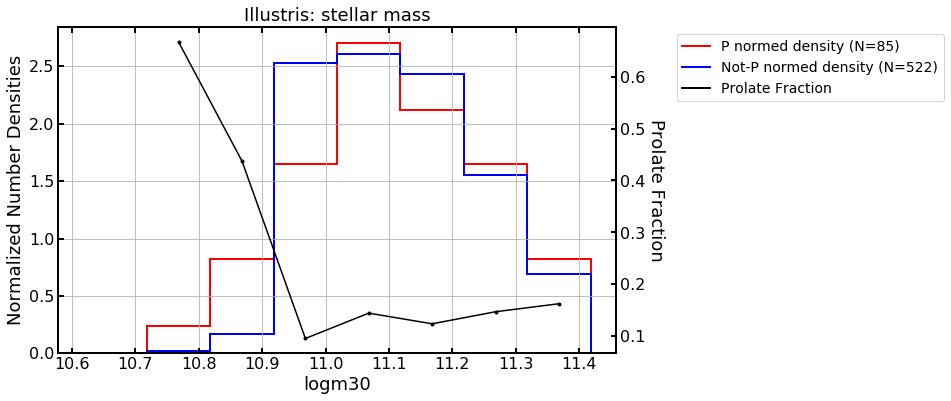

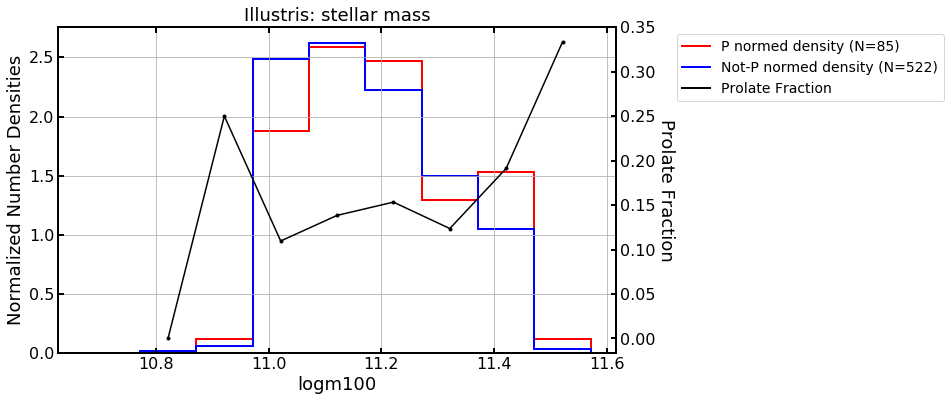

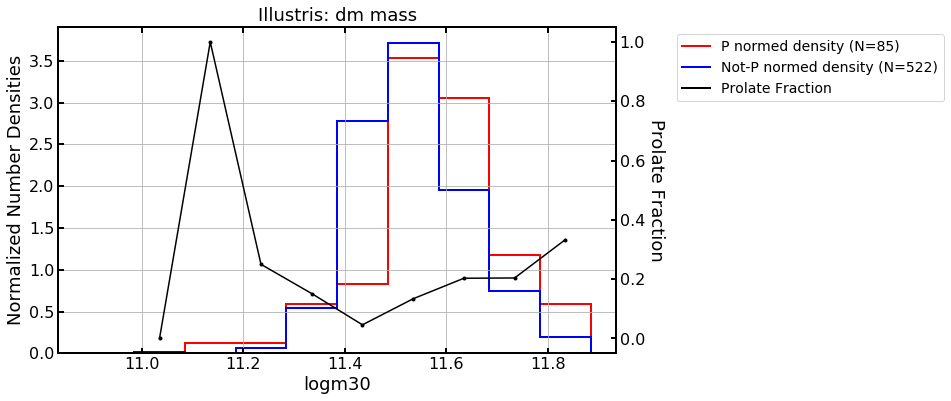

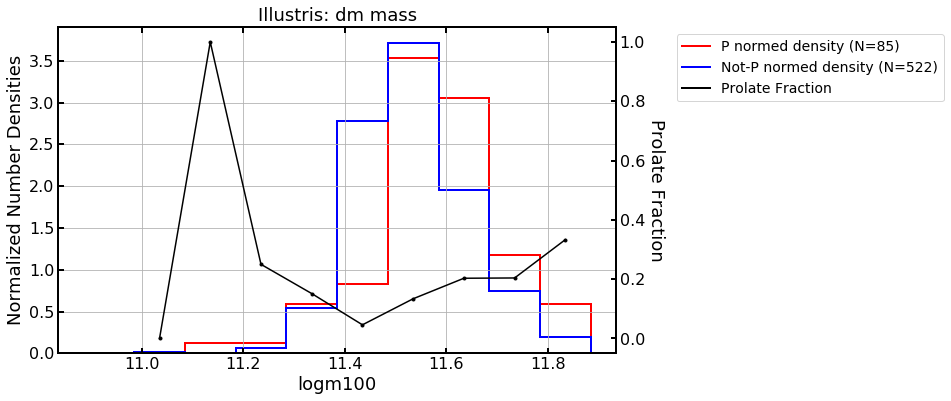

In [10]:
for mass_type in logms:
    for key in logms[mass_type]:
        logmass = logms[mass_type][key]
        m_arr = np.arange( min(logmass) - 0.1, max(logmass) + 0.1, 0.1 )
        # plot normed densities
        fig, ax1 = plt.subplots()
        ind1 = np.where( shape_data['shape'] == 'P' )[0]
        ax1.hist(logmass[ind1], histtype='step', lw=2, bins=m_arr, color='r',
                 label='Prolate normed density (N=%s)' % len(ind1), density=True )
        ind2 = np.where( shape_data['shape'] != 'P')[0]
        ax1.hist(logmass[ind2], histtype='step', bins=m_arr, color='b',
                 lw=2, label='Not-Prolate normed density (N=%s)' % len(ind2), density=True )
        ax1.set_xlabel( key )
        ax1.set_ylabel( 'Normalized Number Densities' )
        # plot fraction
        ax2 = ax1.twinx()
        frac, ms = [], []
        for j in range(len(m_arr) - 1):
            mlow, mupp = m_arr[j], m_arr[j+1]
            ind = np.where( ( logmass >= mlow ) & ( logmass < mupp ))[0]
            if len(ind) > 0:
                frac.append( len( set(ind1) & set(ind) ) / len( ind) )
                ms.append( np.median( [mlow, mupp ]) )
        ax2.plot(ms, frac, 'k.-', label='Prolate Fraction')
        # details
        ax2.set_ylabel( 'Prolate Fraction', rotation=-90, labelpad=20)

        plt.title('Illustris: %s mass' %mass_type)
        custom_lines = [Line2D([0], [0], color='r', lw=2),
                    Line2D([0], [0], color='b', lw=2),
                    Line2D([0], [0], color='k', lw=2)]
        plt.legend(custom_lines,
                   ['P normed density (N=%s)' % len(ind1),
                    'Not-P normed density (N=%s)' % len(ind2),
                    'Prolate Fraction'],
                   bbox_to_anchor=(1.6,1), frameon=True)
        ax2.grid(None)

        plt.show()